In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score, precision_score
from sklearn.ensemble import RandomForestClassifier

In [45]:
data = pd.read_csv('fraud_detection.csv')
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [46]:
#Count of number of unique values vital for encoding method chosen
# Define the threshold for the number of unique values
threshold = 1000

# Iterate over columns
for column in data:  # Add other column names as needed
    unique_values = data[column].nunique()
    if unique_values <= threshold:
        print(f"Number of unique values for '{column}': {unique_values}")
    else:
        print(f"Skipping '{column}' column due to too many unique values.")

Number of unique values for 'step': 743
Number of unique values for 'type': 5
Skipping 'amount' column due to too many unique values.
Skipping 'nameOrig' column due to too many unique values.
Skipping 'oldbalanceOrg' column due to too many unique values.
Skipping 'newbalanceOrig' column due to too many unique values.
Skipping 'nameDest' column due to too many unique values.
Skipping 'oldbalanceDest' column due to too many unique values.
Skipping 'newbalanceDest' column due to too many unique values.
Number of unique values for 'isFraud': 2
Number of unique values for 'isFlaggedFraud': 2


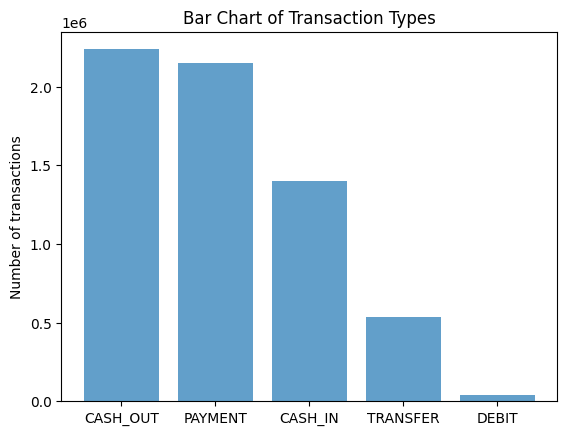

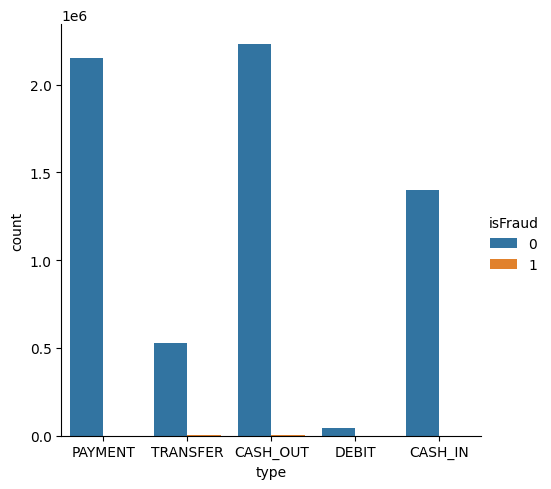

In [47]:
#Counting number of transactions based on type
type_count = data['type'].value_counts()
plt.bar(type_count.index, type_count, alpha = 0.7)
plt.title('Bar Chart of Transaction Types')
plt.ylabel('Number of transactions')
plt.show()

#Comparing Fraud & NonFraud counts
fraud_count = data['isFraud'].value_counts()
sns.catplot(x='type',hue='isFraud',data=data,kind="count")

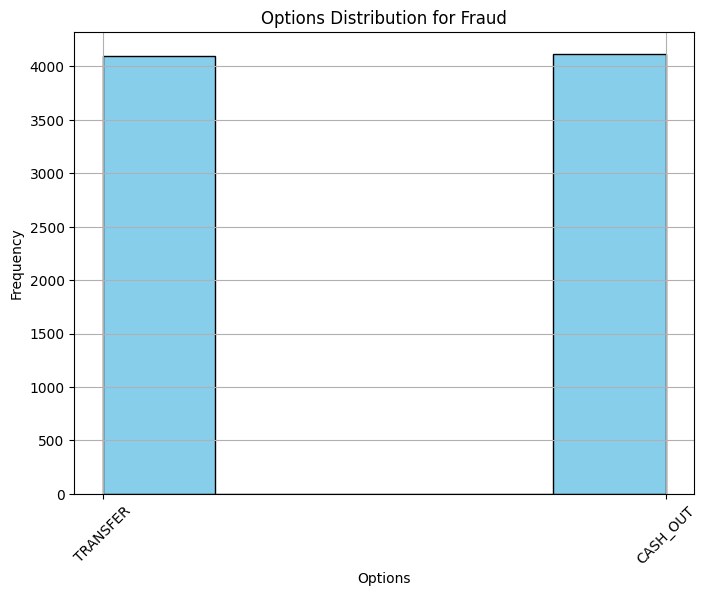

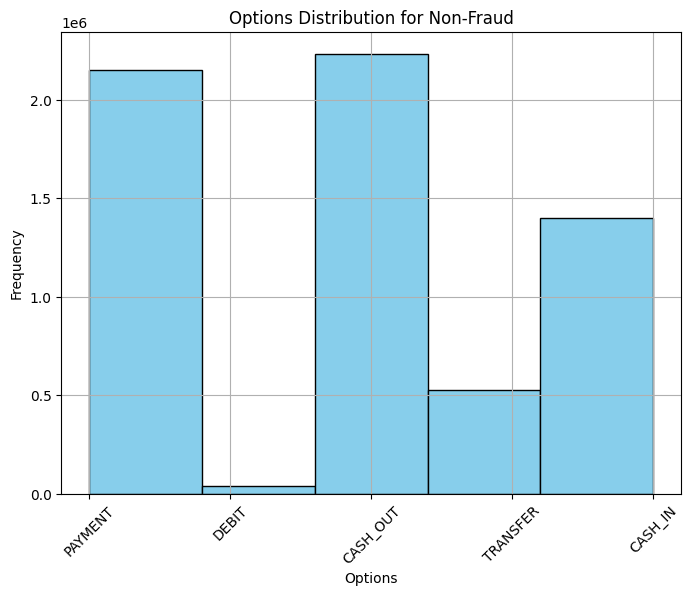

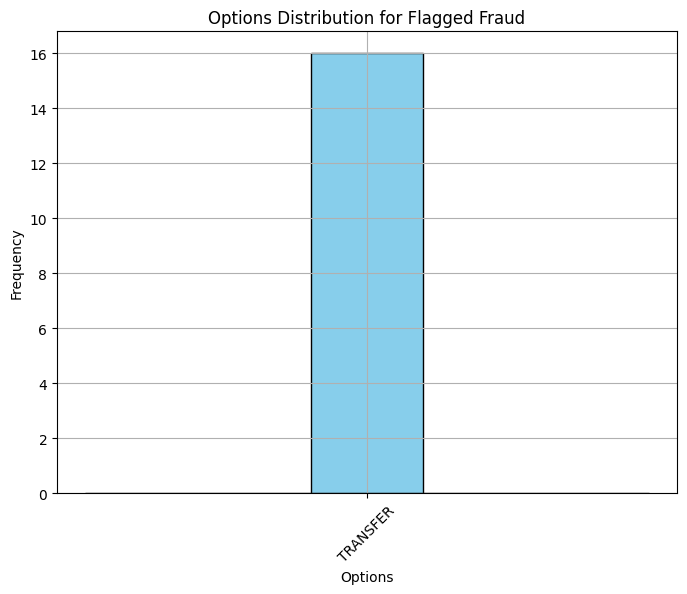

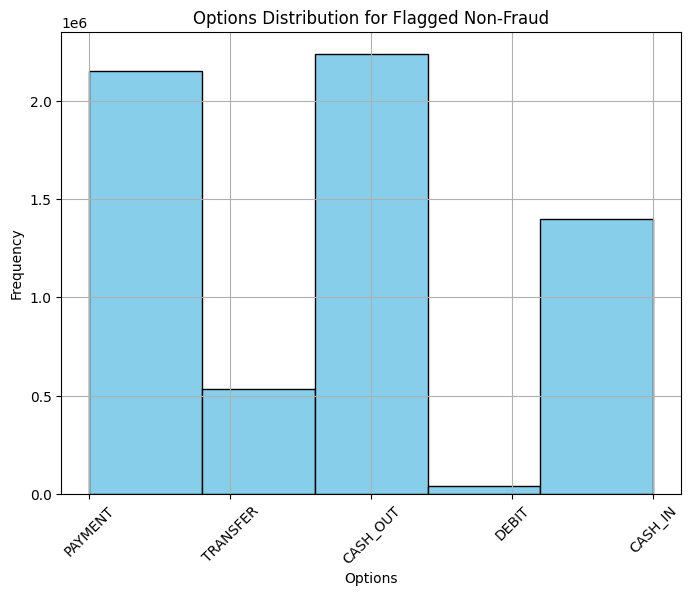

In [48]:
isFraud_1 = data[data['isFraud'] == 1]
isntFraud_1 = data[data['isFraud'] == 0]
isFlaggedFraud_1 = data[data['isFlaggedFraud'] == 1]
isntFlaggedFraud_1 = data[data['isFlaggedFraud'] == 0]
#Fraud types of transactions
plt.figure(figsize=(8,6))
plt.hist(isFraud_1['type'], bins=5, color='skyblue', edgecolor='black')
plt.title('Options Distribution for Fraud')
plt.xlabel('Options')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

#Non Fraud types of transactions for comparison
plt.figure(figsize=(8,6))
plt.hist(isntFraud_1['type'], bins=5, color='skyblue', edgecolor='black')
plt.title('Options Distribution for Non-Fraud')
plt.xlabel('Options')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

#Flagged for fraud types of transactions
plt.figure(figsize=(8,6))
plt.hist(isFlaggedFraud_1['type'], bins=5, color='skyblue', edgecolor='black')
plt.title('Options Distribution for Flagged Fraud')
plt.xlabel('Options')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

#Not flagged for fraud types of transactions for comparison
plt.figure(figsize=(8,6))
plt.hist(isntFlaggedFraud_1['type'], bins=5, color='skyblue', edgecolor='black')
plt.title('Options Distribution for Flagged Non-Fraud')
plt.xlabel('Options')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

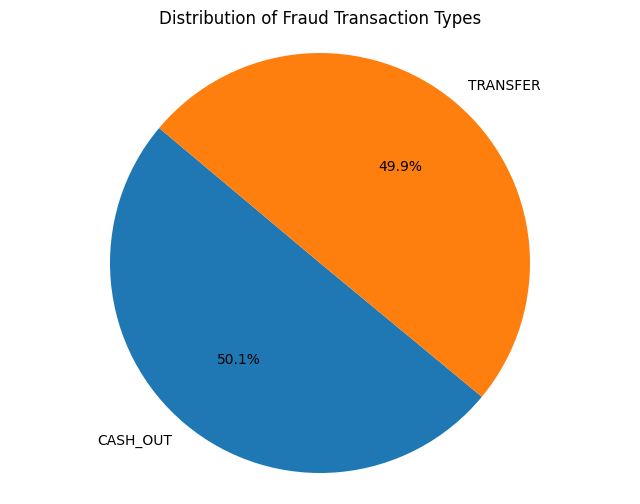

In [49]:
#Pie chart distribution of types of fraud
type_count_isFraud_1 = pd.Series(isFraud_1['type']).value_counts()
labels = type_count_isFraud_1.index.tolist()
sizes = type_count_isFraud_1.values.tolist()
plt.figure(figsize=(8,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Fraud Transaction Types')
plt.axis('equal')
plt.show()

In [50]:
#Dropping FlaggedFraud, only considering fully confirmed fraud cases to improve accuracy of model as testing parameter
data_2 = data.drop(['isFlaggedFraud','step'], axis=1)

#Seperating fraud & nonfraud data
isFraud_2 = data_2[data_2['isFraud'] == 1]
isntFraud_2 = data_2[data_2['isFraud']== 0]

#CashOut & 'TRANSFER' have duplicate values
duplicate_pairs = isFraud_2[isFraud_2.duplicated(subset=['amount'], keep=False)]

fraud_pairs = duplicate_pairs[
    ((duplicate_pairs['type'] == 'TRANSFER') & (duplicate_pairs['type'].shift(-1) == 'CASH_OUT')) |
    ((duplicate_pairs['type'] == 'CASH_OUT') & (duplicate_pairs['type'].shift(-1) == 'TRANSFER'))
]

#Comparing fraud & nonfraud mean transaction values
mean_fraud_transaction = isFraud_2['amount'].mean()
mean_nonfraud_transaction = isntFraud_2['amount'].mean()
print(mean_fraud_transaction)
print(mean_nonfraud_transaction)

#Encoding
# Initialising the OneHotEncoder
encoder = OneHotEncoder()

# Fit and transform the 'type' column
encoded_type = encoder.fit_transform(data_2[['type']])

1467967.299140387
178197.04172740763


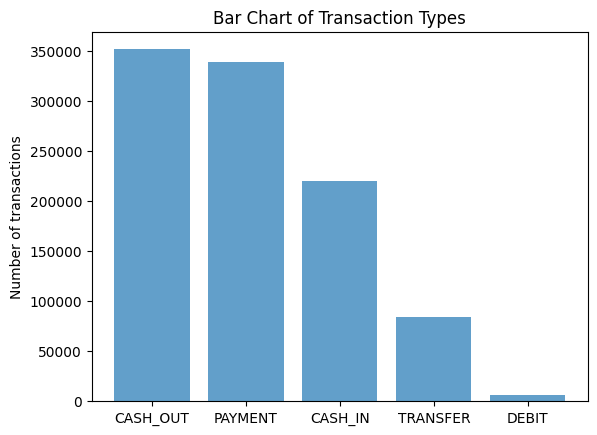

1371752.8674249605
178989.90421935168


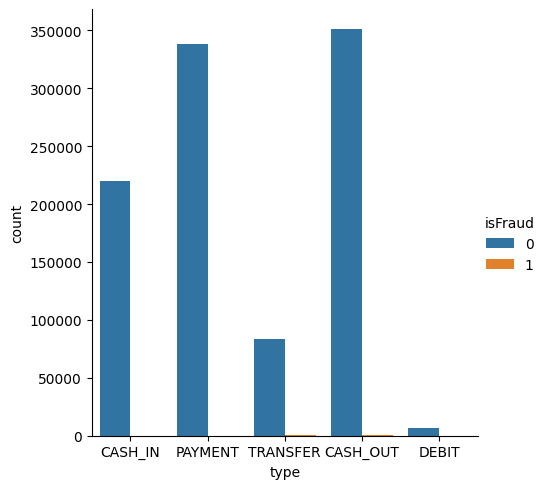

In [51]:
# Sampling a subset of the data to reduce run time 
sample_size = 1000000  # Adjust the sample size as needed
data_sample = data.sample(n=sample_size, random_state=42)  # Randomly sample 'sample_size' rows

# Comparing count of transaction types from sample
type_count = data_sample['type'].value_counts()
plt.bar(type_count.index, type_count, alpha=0.7)
plt.title('Bar Chart of Transaction Types')
plt.ylabel('Number of transactions')
plt.show()

fraud_count = data_sample['isFraud'].value_counts()
sns.catplot(x='type', hue='isFraud', data=data_sample, kind="count")

# Feature Engineering
data_2 = data_sample.drop(['isFlaggedFraud', 'step'], axis=1)

isFraud_2 = data_2[data_2['isFraud'] == 1]
isntFraud_2 = data_2[data_2['isFraud'] == 0]

# Filtering out duplicate pairs with 'TRANSFER' followed by 'CASH_OUT' or vice versa
duplicate_pairs = isFraud_2[isFraud_2.duplicated(subset=['amount'], keep=False)]

fraud_pairs = duplicate_pairs[
    ((duplicate_pairs['type'] == 'TRANSFER') & (duplicate_pairs['type'].shift(-1) == 'CASH_OUT')) |
    ((duplicate_pairs['type'] == 'CASH_OUT') & (duplicate_pairs['type'].shift(-1) == 'TRANSFER'))
]

mean_fraud_transaction = isFraud_2['amount'].mean()
mean_nonfraud_transaction = isntFraud_2['amount'].mean()
print(mean_fraud_transaction)
print(mean_nonfraud_transaction)

# Encoding
# Initialize OneHotEncoder
encoder = OneHotEncoder()

# Reset index of data_2
data_2.reset_index(drop=True, inplace=True)

# Fit and transform the 'type' column
encoded_type = encoder.fit_transform(data_2[['type']])

# Create DataFrame with encoded data
df_encoded = pd.DataFrame(encoded_type.toarray(), columns=encoder.get_feature_names_out(['type']))

# Concatenate the encoded DataFrame with the original DataFrame
df_final = pd.concat([data_2.drop('type', axis=1), df_encoded], axis=1)

# Drop the columns "nameOrig" and "nameDest" from the DataFrame
df_final = df_final.drop(['nameOrig', 'nameDest'], axis=1)

In [52]:
# Filter data_2 to include only the rows present in fraud_pairs
fraud_pairs_data = data_2.loc[data_2.index.isin(fraud_pairs.index)].copy()

# Set 'isFraud' column to 1 for all rows in fraud_pairs_data
fraud_pairs_data.loc[:, 'isFraud'] = 1

# Check if fraud_pairs_data contains at least one row
if len(fraud_pairs_data) > 0:
    # Reset index of fraud_pairs_data
    fraud_pairs_data.reset_index(drop=True, inplace=True)

    # Initialize OneHotEncoder
    encoder = OneHotEncoder()

    # Fit and transform the 'type' column
    encoded_type_fraud_pairs = encoder.fit_transform(fraud_pairs_data[['type']])

    # Create DataFrame with encoded data
    df_encoded_fraud_pairs = pd.DataFrame(encoded_type_fraud_pairs.toarray(), columns=encoder.get_feature_names_out(['type']))

    # Concatenate the encoded DataFrame with the original DataFrame
    df_final_fraud_pairs = pd.concat([fraud_pairs_data.drop('type', axis=1), df_encoded_fraud_pairs], axis=1)

    # Print the DataFrame containing only fraud_pairs and their encoded 'type' column
    print(df_final_fraud_pairs)
else:
    print("No fraud pairs found in the dataset.")

      amount     nameOrig  oldbalanceOrg  newbalanceOrig     nameDest  \
0   20819.51   C674595914        7706.00            0.00   M452881409   
1   41330.78   C315204123           0.00            0.00   C688516052   
2  321671.68   C796412458           0.00       321671.68  C1961746653   
3  153282.06   C231998401     5207107.91      5360389.97     C1271998   
4   31645.57  C1596554077           0.00            0.00   C770091069   
5  155165.91  C1341615369           0.00            0.00   C172063096   
6   51628.76   C156797011           0.00            0.00  C1577414088   
7  177510.54    C52817969           0.00            0.00  C1582765215   

   oldbalanceDest  newbalanceDest  isFraud  type_CASH_IN  type_CASH_OUT  \
0            0.00            0.00        1           0.0            0.0   
1       147097.83       188428.61        1           0.0            1.0   
2       519253.47       197581.79        1           1.0            0.0   
3     14921461.73     14768179.67        1

In [53]:
#Random Forest Model

# Split the data into features (X) and target variable (y)
X = df_final.drop('isFraud', axis=1)  # Features
y = df_final['isFraud']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the regression model (e.g., Logistic Regression)
model = LogisticRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model (example: calculate accuracy)
accuracy = accuracy_score(y_test, y_pred)

# Print evaluation result
print("Accuracy:", accuracy)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print evaluation metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.9993
Confusion Matrix:
[[199754     13]
 [   127    106]]
Precision: 0.8907563025210085
Recall: 0.45493562231759654
F1-score: 0.6022727272727273


In [54]:
# Initialize the Random Forest Classifier
model_forest = RandomForestClassifier()

# Train the model
model_forest.fit(X_train, y_train)

# Make predictions on the test set
y_pred_forest = model_forest.predict(X_test)

# Evaluate the model
accuracy_forest = accuracy_score(y_test, y_pred_forest)
precision_forest = precision_score(y_test, y_pred_forest)
recall_forest = recall_score(y_test, y_pred_forest)
f1_forest = f1_score(y_test, y_pred_forest)

# Print evaluation metrics
print("Accuracy:", accuracy_forest)
print("Precision:", precision_forest)
print("Recall:", recall_forest)
print("F1-score:", f1_forest)

# Calculate confusion matrix
conf_matrix_forest = confusion_matrix(y_test, y_pred_forest)
print("Confusion Matrix:")
print(conf_matrix_forest)

Accuracy: 0.999675
Precision: 0.9772727272727273
Recall: 0.7381974248927039
F1-score: 0.8410757946210269
Confusion Matrix:
[[199763      4]
 [    61    172]]


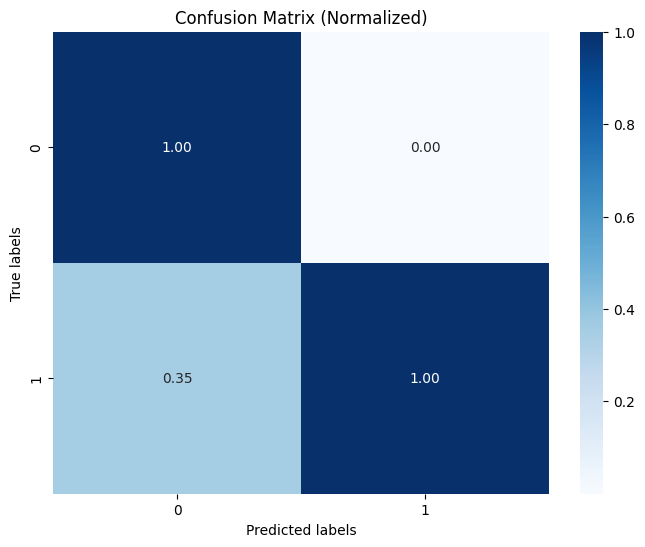

In [55]:
plt.figure(figsize=(8, 6))

# Normalise each row separately
normalized_conf_matrix = conf_matrix_forest / np.max(conf_matrix_forest, axis=1)[:, np.newaxis]

# Plot the heatmap with normalized values
sns.heatmap(normalized_conf_matrix, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix (Normalized)')
plt.show()

In [56]:
#XGBoost model

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid with reduced options
param_grid = {
    'n_estimators': [50, 100],  # Reduced number of trees for early stopping
    'max_depth': [3, 6],  # Adjust the maximum depth of trees
    'learning_rate': [0.1, 0.3],  # Adjust the learning rate
    'min_child_weight': [1, 3]  # Adjust the minimum sum of instance weight
}

# Initialize the XGBoost Classifier
xgb = XGBClassifier(random_state=42, early_stopping_rounds=10)

# Initialize Grid Search with cross-validation
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

# Perform Grid Search
grid_search.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Get the best model
best_xgb = grid_search.best_estimator_

# Evaluate the best model
y_pred = best_xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Hyperparameters: {'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100}
Accuracy: 0.99967
Precision: 0.946524064171123
Recall: 0.759656652360515
F1-score: 0.8428571428571429
Confusion Matrix:
[[199757     10]
 [    56    177]]


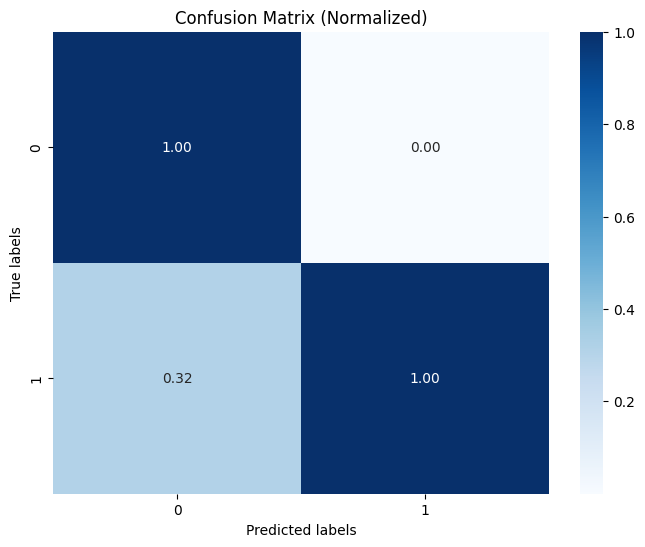

In [57]:
plt.figure(figsize=(8, 6))

# Normalise each row separately
normalized_conf_matrix = conf_matrix / np.max(conf_matrix, axis=1)[:, np.newaxis]

# Plot the heatmap with normalized values
sns.heatmap(normalized_conf_matrix, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix (Normalized)')
plt.show()

In [58]:
#Improving recall within neural network

import tensorflow as tf
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the neural network architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=5, batch_size=32, validation_split=0.2)

# Evaluate the model
y_pred_proba = model.predict(X_test_scaled)
y_pred_nn = (y_pred_proba > 0.1).astype(int) 
accuracy_nn = accuracy_score(y_test, y_pred_nn)
precision_nn = precision_score(y_test, y_pred_nn)
recall_nn = recall_score(y_test, y_pred_nn)
f1_nn = f1_score(y_test, y_pred_nn)

# Print evaluation metrics
print("Neural Network - Accuracy:", accuracy_nn)
print("Neural Network - Precision:", precision_nn)
print("Neural Network - Recall:", recall_nn)
print("Neural Network - F1-score:", f1_nn)

# Calculate confusion matrix
conf_matrix_nn = confusion_matrix(y_test, y_pred_nn)
print("Neural Network - Confusion Matrix:")
print(conf_matrix_nn)

c:\Users\abdif\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 29s 1ms/step - accuracy: 0.9966 - loss: 0.0127 - val_accuracy: 0.9991 - val_loss: 0.0048
Epoch 2/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step - accuracy: 0.9992 - loss: 0.0045 - val_accuracy: 0.9993 - val_loss: 0.0037
Epoch 3/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step - accuracy: 0.9992 - loss: 0.0043 - val_accuracy: 0.9993 - val_loss: 0.0033
Epoch 4/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step - accuracy: 0.9993 - loss: 0.0039 - val_accuracy: 0.9994 - val_loss: 0.0030
Epoch 5/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step - accuracy: 0.9993 - loss: 0.0039 - val_accuracy: 0.9993 - val_loss: 0.0032
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 5s 775us/step
Neural Network - Accuracy: 0.99947
Neural Network - Precision: 0.950354609929078
Neural Network - Recall: 0.575107296137339
Neural Network - F1-score: 0.7165775401069518
Neural Network - Confusion Matrix:
[[199760      7]
 [    99    134]]


In [59]:
#Improving recall further within Neural Network

# Calculate class weights manually based on class distribution
class_counts = np.bincount(y_train)
total_samples = np.sum(class_counts)
class_weights = {cls: total_samples / count for cls, count in enumerate(class_counts)}

# Calculate sample weights
sample_weights = np.array([class_weights[cls] for cls in y_train])

# Define the neural network architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with sample weights
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2, sample_weight=sample_weights)

# Evaluate the model
y_pred_proba = model.predict(X_test_scaled)
y_pred_nn = (y_pred_proba > 0.5).astype(int)  # Using threshold of 0.5
accuracy_nn = accuracy_score(y_test, y_pred_nn)
precision_nn = precision_score(y_test, y_pred_nn)
recall_nn = recall_score(y_test, y_pred_nn)
f1_nn = f1_score(y_test, y_pred_nn)

# Print evaluation metrics
print("Neural Network - Accuracy:", accuracy_nn)
print("Neural Network - Precision:", precision_nn)
print("Neural Network - Recall:", recall_nn)
print("Neural Network - F1-score:", f1_nn)

# Calculate confusion matrix
conf_matrix_nn = confusion_matrix(y_test, y_pred_nn)
print("Neural Network - Confusion Matrix:")
print(conf_matrix_nn)

Epoch 1/10


c:\Users\abdif\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20000/20000 ━━━━━━━━━━━━━━━━━━━━ 23s 1ms/step - accuracy: 0.8407 - loss: 1.3007 - val_accuracy: 0.7238 - val_loss: 0.5729
Epoch 2/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step - accuracy: 0.8491 - loss: 0.6976 - val_accuracy: 0.9902 - val_loss: 0.5497
Epoch 3/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step - accuracy: 0.8696 - loss: 0.9416 - val_accuracy: 0.9491 - val_loss: 0.8403
Epoch 4/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step - accuracy: 0.8638 - loss: 1.1084 - val_accuracy: 0.9000 - val_loss: 0.7350
Epoch 5/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 41s 1ms/step - accuracy: 0.8568 - loss: 0.8187 - val_accuracy: 0.9840 - val_loss: 0.7519
Epoch 6/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step - accuracy: 0.8746 - loss: 0.6503 - val_accuracy: 0.8187 - val_loss: 0.5899
Epoch 7/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step - accuracy: 0.8727 - loss: 0.6040 - val_accuracy: 0.9875 - val_loss: 0.6336
Epoch 8/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 41s 1ms/step - accuracy: 0.8698 - lo

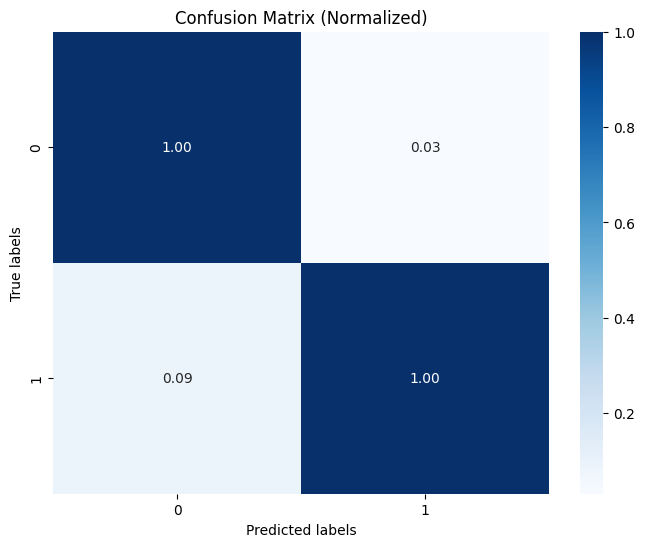

In [60]:
plt.figure(figsize=(8, 6))

# Normalize each row separately
normalised_conf_matrix = conf_matrix_nn / np.max(conf_matrix_nn, axis=1)[:, np.newaxis]

# Plot the heatmap with normalized values
sns.heatmap(normalised_conf_matrix, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix (Normalized)')
plt.show()